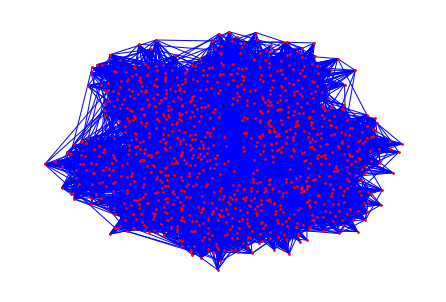

In [1]:
# Generate an LFR Network and Draw it
import numpy as np
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph


n = 1000
tau1 = 2  # Power-law exponent for the degree distribution
tau2 = 1.1  # Power-law exponent for the community size distribution
#mu = 0.02  # Mixing parameter
avg_deg = 25  # Average Degree
max_deg = int(0.1 * n)  # Max Degree
min_commu = 60  # Min Community Size
max_commu = int(0.1 * n)  # Max Community Size

for mu in np.arange(0.1, 0.11, 0.1):
    G = LFR_benchmark_graph(
        n, tau1, tau2, mu, average_degree=avg_deg, max_degree=max_deg, min_community=min_commu, max_community=max_commu,
        seed=7
    )

    # Remove multi-edges and self-loops from G
    G = nx.Graph(G)
    selfloop_edges = list(nx.selfloop_edges(G))
    G.remove_edges_from(selfloop_edges)


    nx.draw(G, pos=nx.spring_layout(G),node_color='r', node_size=3, edge_color='b')

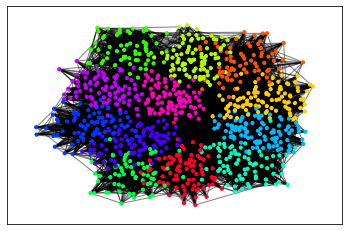

In [2]:
# LFR 图是有内在的社群结构的，每个节点的社群存储在其 community 属性中，是一个 set
# 通过运行循环，按照内在的社群结构给每个节点一个标签 即为其 intrinsic_membership
# 为了方便 intrinsic_membership 一开始是作为一个 dict 存储的，后来将其转化为一个 list
intrinsic_communities = {frozenset(G.nodes[v]["community"]) for v in G}
intrinsic_membership = {}
for node in range(G.number_of_nodes()):
    for index, inner_set in enumerate(intrinsic_communities):
        if node in inner_set:
            intrinsic_membership[node] = index
            break
intrinsic_membership = list(intrinsic_membership.values())

# intrinsic_membership is a list stroing the intrinsic membership of each node

# 对于每个节点，按照其 intrinsic_membership 着色画图
from community import community_louvain
import matplotlib
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,
                      pos,
                      node_size=10,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=intrinsic_membership
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [3]:
# Get the edge list and edge weights and transform G from NetworkX to Network
from Network import *
import numpy as np

# Get edge list as a numpy array
edge_list = list(G.edges())
edge_list = np.array(edge_list)

# Get edge weights as a numpy array
edge_weights = nx.get_edge_attributes(G, 'weight')
edge_weights = np.array(edge_weights)

edge_weights = [edge_weights[edge] if edge in edge_weights else 1 for edge in edge_list]

Gn = Network(edge_list, edge_weights)
# Gn is the representation of G in Network format

In [4]:
# Calculate effective resistance
epsilon=0.1
method='spl'
Effective_R = Gn.effR(epsilon, method)

# spectral sparse version of G in Network format
q = 10000
seed = 2020
Gn_Sparse = Gn.spl(q, Effective_R, seed=2020)

In [5]:
import networkx as nx
import scipy.sparse

def to_networkx(self):
    if isinstance(self.graph, scipy.sparse.csr.csr_matrix):
        return nx.from_scipy_sparse_matrix(self.graph)
    else:
        return nx.from_numpy_array(self.graph)

# G_sparse is the spectral sparse version of G in NetworkX format    
G_sparse = to_networkx(Gn_Sparse)
# check whether the sparse version is connected or not
nx.is_connected(G_sparse)

/tmp/ipykernel_32374/1628658021.py:5: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if isinstance(self.graph, scipy.sparse.csr.csr_matrix):


True

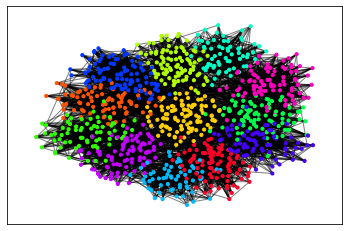

In [6]:
# This is a quick test. I did community detection with Louvain method on G_sparse and 
# draw G with the Louvain detected community structure on G_sparse.
# The result seems OK.
from community import community_louvain

partition = community_louvain.best_partition(G_sparse)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G,
                      pos,
                      #partition.keys(),
                      node_size=10,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(partition.values())
                      )
nx.draw_networkx_edges(G_sparse, pos, alpha=0.5)

In [7]:
# This is the function for Laplacian Eigenmap using Cupy. The presence of GPU is required.

import numpy as np
import networkx as nx
import cupy as cp

def lap_cupy(graph, dim):
    """
    Compute the Laplacian embedding of a graph using CuPy.

    Parameters:
    graph (networkx.classes.graph.Graph): The input graph.
    dim (int): The dimension of the embedding.

    Returns:
    numpy.ndarray: The Laplacian embedding of the graph.
    """
    # Check inputs
    assert isinstance(graph, nx.Graph), "Input graph must be a NetworkX graph."
    assert isinstance(dim, int) and dim > 0, "Input dim must be a positive integer."
    assert dim < graph.number_of_nodes(), "Input dim must be less than the number of nodes in the graph."

    # Convert the adjacency matrix of the graph to a CuPy array
    A = cp.asarray(nx.adjacency_matrix(graph, nodelist=graph.nodes(), weight='weight').toarray(), dtype=cp.float64)

    # Compute L1 normalization along axis 1 (rows)
    row_sums = cp.linalg.norm(A, ord=1, axis=1)
    A /= row_sums.reshape(-1, 1)

    # Compute the eigenvalues and eigenvectors of I_n - A
    I_n = cp.eye(graph.number_of_nodes())
    w, v = cp.linalg.eigh(I_n - A)

    # Sort the eigenvectors by the real part of the eigenvalues
    v = v[:, cp.argsort(w.real)]

    # Return the embedding
    return v[:, 1:(dim+1)].get().real  # Explicitly convert to NumPy array using .get()

In [8]:
%%time
# A quick test of the aforementioned funciton.
# lap_cupy(G_sparse,3)

/tmp/ipykernel_32374/3981420276.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = cp.asarray(nx.adjacency_matrix(graph, nodelist=graph.nodes(), weight='weight').toarray(), dtype=cp.float64)


CPU times: user 760 ms, sys: 809 ms, total: 1.57 s
Wall time: 9.35 s


array([[ 0.00533101, -0.00704894,  0.00703625],
       [ 0.02865842, -0.05341453, -0.02755205],
       [-0.03661844,  0.00973269,  0.00463911],
       ...,
       [ 0.01539866, -0.00044734, -0.01026787],
       [ 0.00994542, -0.00598471, -0.00896526],
       [ 0.02412684,  0.03746045, -0.0660191 ]])

In [9]:
%%time
# This function takes the orthogonal part of G_sparse eigenvectors.
# Hopefully, we will get a better community detection result from this treatment.
import networkx as nx
import numpy as np

def compute_orthogonal_components(G, V):
    """
    Compute the component of each column of V orthogonal to the degree sequence vector of a graph.

    Parameters:
    G (networkx.classes.graph.Graph): The input graph.
    V (numpy.ndarray): The input 2D array.

    Returns:
    numpy.ndarray: The component of each column of V orthogonal to the degree sequence vector of the graph.
    """
    # get measure and constant vector
    mu = np.array([d for n, d in G.degree()])
    u = np.ones(G.number_of_nodes())

    # 
    orthogonal_components = np.zeros_like(V)

    # do orthogonal for each column
    for i in range(V.shape[1]):
        v = V[:, i]
        orthogonal_component = v - ((v @ (u * mu)) / (u @ (u * mu))) * u
        orthogonal_components[:, i] = orthogonal_component  # 

    return orthogonal_components

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 10.5 µs


In [10]:
# A quick test of the aforementioned funciton.
# compute_orthogonal_components(G, lap_cupy(G_sparse,3))

/tmp/ipykernel_32374/3981420276.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = cp.asarray(nx.adjacency_matrix(graph, nodelist=graph.nodes(), weight='weight').toarray(), dtype=cp.float64)


array([[ 0.00190716, -0.00440164,  0.00709693],
       [ 0.02523458, -0.05076723, -0.02749137],
       [-0.04004229,  0.01237999,  0.00469979],
       ...,
       [ 0.01197481,  0.00219996, -0.01020719],
       [ 0.00652157, -0.00333741, -0.00890458],
       [ 0.02070299,  0.04010775, -0.06595842]])

In [11]:
### KMeans Clustering using Euclidean and Spherical metrics
### Using NMI and ECSim for comparison
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score
import clusim.sim as sim
from clusim.clustering import Clustering


def euclid_membership(K, points):
    euc_kmeans = KMeans(n_clusters=K, n_init=10)
    euc_kmeans.fit(points)

    evala_euclid_membership = euc_kmeans.labels_
    return evala_euclid_membership

def cosine_membership(K, points):
    normalized_points = normalize(points)
    cos_kmeans = KMeans(n_clusters=K, n_init=10)
    cos_kmeans.fit(normalized_points)

    evala_cosine_membership = cos_kmeans.labels_
    return evala_cosine_membership

def calculate_score(evala, intr_list, K):
# evala is the embedding vectors
# intr_list is the intrinsic community strucuture
# K is the number of clusters in Kmeans
    return_val = [] # 首先准备好返回值 

    intr_clus = Clustering({i: [intr_list[i]] for i in range(len(intr_list))})

    evala_euclid_membership = euclid_membership(K, evala)

    evala_cosine_membership = cosine_membership(K, evala)

    ## compare with intrinsic community structure using NMI
    return_val.append(normalized_mutual_info_score(evala_euclid_membership, intr_list, average_method='arithmetic'))
    return_val.append(normalized_mutual_info_score(evala_cosine_membership, intr_list, average_method='arithmetic'))
    
    
    evala_euclid_clustering = Clustering(elm2clu_dict={i: [evala_euclid_membership[i]] for i in range(len(evala_euclid_membership))})
    evala_cosine_clustering = Clustering(elm2clu_dict={i: [evala_cosine_membership[i]] for i in range(len(evala_cosine_membership))})
    
    ## compare with intrinsic community structure using ECSim
    evala_euclid_similarity = sim.element_sim(intr_clus, evala_euclid_clustering, alpha=0.9)
    evala_cosine_similarity = sim.element_sim(intr_clus, evala_cosine_clustering, alpha=0.9)
    return_val.append(evala_euclid_similarity)
    return_val.append(evala_cosine_similarity)
    
    return return_val

In [15]:
K = 30
# calculate_score gives four scores.
# We explain each entry in the score vectors
# The first is the NMI between the intrinsic community structure and the tested community structure using LAP with Euclidean distance
# The second is the NMI between the intrinsic community structure and the tested community structure using LAP with Spherical distance
# The third is the ECS between the intrinsic community structure and the tested community structure using LAP with Euclidean distance
# The fourth is the ECS between the intrinsic community structure and the tested community structure using LAP with Spherical distance

# sparse with orthogonal
%time
print(type(calculate_score(compute_orthogonal_components(G, lap_cupy(G_sparse,K)),intrinsic_membership, len(np.unique(intrinsic_membership))))
     )
# sparse w/o orthogonal
%time
print(calculate_score(lap_cupy(G_sparse,K),intrinsic_membership, len(np.unique(intrinsic_membership))))

# non-sparse
%time
print(calculate_score(lap_cupy(G,K),intrinsic_membership, len(np.unique(intrinsic_membership))))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


/tmp/ipykernel_32374/3981420276.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = cp.asarray(nx.adjacency_matrix(graph, nodelist=graph.nodes(), weight='weight').toarray(), dtype=cp.float64)


<class 'list'>
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.34 µs


/tmp/ipykernel_32374/3981420276.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = cp.asarray(nx.adjacency_matrix(graph, nodelist=graph.nodes(), weight='weight').toarray(), dtype=cp.float64)


[0.9278092536105336, 0.9933480482125869, 0.832693057196772, 0.9911216509655218]
CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.48 µs


/tmp/ipykernel_32374/3981420276.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = cp.asarray(nx.adjacency_matrix(graph, nodelist=graph.nodes(), weight='weight').toarray(), dtype=cp.float64)


[0.9725996536110613, 1.0, 0.9256710736052507, 1.0]
